# Install package

In [ ]:
%%capture
!pip install pydub
!pip install noisereduce

In [ ]:
%%capture
!pip install pywt
!pip install json-tricks

# Download dataset

In [ ]:
%%capture
!gdown --id 13N_zbQxl44rzhihNX9aTykHDqWbMNx2q
!unzip /content/archive.zip

In [ ]:
%%capture
# !mkdir -p RAVDESS
%cd RAVDESS
# !gdown --id 1oi0o77RTpfTGcJbptYQ9n_5ZKIrBsVDy
!unzip /content/RAVDESS/RAVDESS.zip
# %cd ../

In [ ]:
!rm /content/RAVDESS/RAVDESS.zip

# IMPORT

In [ ]:
%%capture
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pydub import AudioSegment, effects
import noisereduce as nr

import librosa
from librosa import display   
import IPython.display as ipd

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout, Activation, BatchNormalization, LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from json_tricks import dump, load

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.optimizers import Adam


# EDP

In [ ]:
#load audio
aud = '/content/RAVDESS/Actor_02/03-01-01-01-01-01-02.wav'

raw = AudioSegment.from_file(aud)
x, sr = librosa.load(aud, sr=None) #native sampling rate of file
raw

Text(0.5, 1.0, 'Original audio')

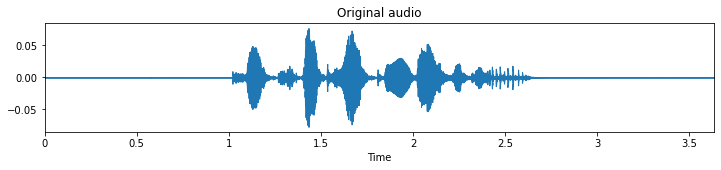

In [ ]:
plt.figure(figsize=(12,2))
librosa.display.waveplot(x, sr)
plt.title('Original audio')

In [ ]:
#increase sound
normalized = effects.normalize(raw, headroom = 5.0) 
normal_x = np.array(normalized.get_array_of_samples(), dtype = 'float32')
normalized

Text(0.5, 1.0, 'Normalized audio')

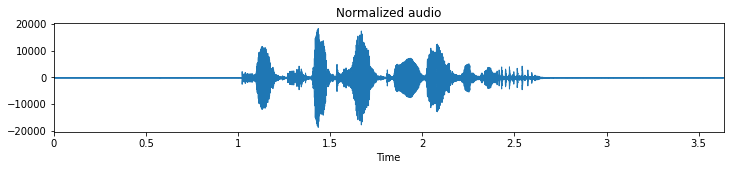

In [ ]:
plt.figure(figsize=(12,2))
librosa.display.waveplot(normal_x, sr)
plt.title('Normalized audio')

In [ ]:
#cut silence
xt, index = librosa.effects.trim(normal_x, top_db = 30)

ipd.display(ipd.Audio(data = xt, rate=sr))

Text(0.5, 1.0, 'Trimmed audio')

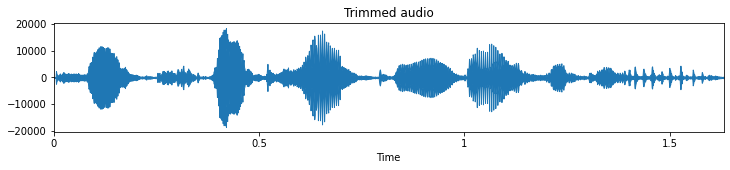

In [ ]:
plt.figure(figsize=(12,2))
librosa.display.waveplot(xt, sr)
plt.title('Trimmed audio')

In [ ]:
final_x = nr.reduce_noise(y=xt, 
                          y_noise=xt, 
                          sr=sr)

ipd.display(ipd.Audio(data = final_x, rate=sr))

Text(0.5, 1.0, 'Noise-reduced audio')

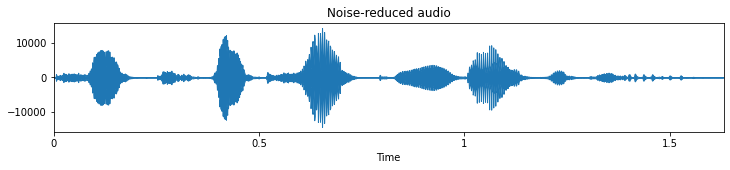

In [ ]:
plt.figure(figsize=(12,2))
librosa.display.waveplot(final_x, sr)
plt.title('Noise-reduced audio')

# Preprocessing

## RAVDESS

In [ ]:
#get audio path
def get_wavpath(name):
  wavlist = []
  for subdir, dirs, files in os.walk(name):
    for file in files: 
      path = os.path.join(subdir,file)
      wavlist.append(path)
  return wavlist 

In [ ]:
ravd = get_wavpath("/content/RAVDESS")
ravd[3]

'/content/RAVDESS/Actor_12/03-01-06-02-02-02-12.wav'

In [ ]:
#get labels 

ravd_labels = []

for path in ravd: 
  lab = path.split('/')[-1].split('-')[2]
  if lab == '01':
    ravd_labels.append('neutral')
  elif lab == '02':
    ravd_labels.append('calm')
  elif lab == '03':
    ravd_labels.append('happy')
  elif lab == '04':
    ravd_labels.append('sad')
  elif lab == '05':
    ravd_labels.append('angry')
  elif lab == '06':
    ravd_labels.append('fearful')
  elif lab == '07': 
    ravd_labels.append('disgusted')
  elif lab == '08':
    ravd_labels.append('surprised')

ravd_labels[3]

'fearful'

## TESS

In [ ]:
tess = get_wavpath('/content/TESS Toronto emotional speech set data')

tess[5]

'/content/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_chair_ps.wav'

In [ ]:
#get labels 

tess_labels = []

for path in tess: 
  lab = path.split('/')[-1].split('_')[2].split('.')[0]
  if lab == 'neutral':
    tess_labels.append('neutral')
  elif lab == 'happy':
    tess_labels.append('happy')
  elif lab == 'sad':
    tess_labels.append('sad')
  elif lab == 'angry':
    tess_labels.append('angry')
  elif lab == 'fear':
    tess_labels.append('fearful')
  elif lab == 'disgust': 
    tess_labels.append('disgusted')
  elif lab == 'ps': 
    tess_labels.append('surprised') 

tess_labels[5]

'surprised'

## General

In [ ]:
#Dataframe 2 datasets

ravd_frame = pd.DataFrame(np.column_stack([ravd, ravd_labels]),
                           columns=['Path', 'Emotion'])

tess_frame = pd.DataFrame(np.column_stack([tess, tess_labels]),
                          columns=['Path', 'Emotion'])

data = pd.concat([ravd_frame, tess_frame],
                 axis=0, ignore_index=True)

#save .csv
data.to_csv('Dataset.csv', header=True)

data = pd.read_csv('Dataset.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


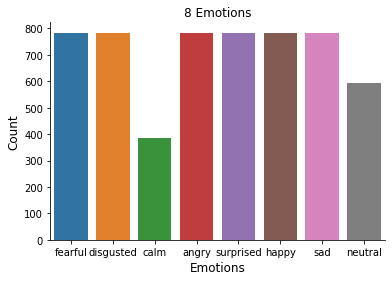

In [ ]:
import seaborn as sns

plt.title('8 Emotions', size=12)
sns.countplot(data.Emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.savefig('count_noaug.png')
plt.show()

# Get features 

## Overview

In [ ]:
data = pd.read_csv('Dataset.csv', index_col=0)

data

,Path,Emotion
0,/content/RAVDESS/Actor_12/03-01-06-02-02-01-12...,fearful
1,/content/RAVDESS/Actor_12/03-01-07-01-02-01-12...,disgusted
2,/content/RAVDESS/Actor_12/03-01-02-02-02-02-12...,calm
3,/content/RAVDESS/Actor_12/03-01-06-02-02-02-12...,fearful
4,/content/RAVDESS/Actor_12/03-01-07-02-01-01-12...,disgusted
...,...,...
5675,/content/TESS Toronto emotional speech set dat...,disgusted
5676,/content/TESS Toronto emotional speech set dat...,disgusted
5677,/content/TESS Toronto emotional speech set dat...,disgusted
5678,/content/TESS Toronto emotional speech set dat...,disgusted


In [ ]:
wavlist = data['Path'].to_list()
labels = data['Emotion'].to_list()
assert len(wavlist) == len(labels)

## Get 42 features 

In [ ]:
import time
tic = time.perf_counter()

rms = []
zcr = []
mfcc = []


for path in wavlist:
  #preprocessing phase
      _, sr = librosa.load(path = path, sr = None)
      raw = AudioSegment.from_file(path) 
      normalized = effects.normalize(raw, headroom = 5.0) 
      normal_x = np.array(normalized.get_array_of_samples(), dtype = 'float32')
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      final_x = nr.reduce_noise(y = xt, y_noise = xt, sr=sr)
       
   # Feature extraction 
      f1 = np.mean(librosa.feature.rms(final_x), axis=1)
      f2 = np.mean(librosa.feature.zero_crossing_rate(final_x, center=True), axis=1)  
      f3 = np.mean(librosa.feature.mfcc(final_x, sr=sr, n_mfcc=40), axis=1)           

      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
  
toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 9.1965 minutes


In [ ]:
f_rms = np.asarray(rms).astype('float32')
f_zcr = np.asarray(zcr).astype('float32')
f_mfccs = np.asarray(mfcc).astype('float32')

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (5680, 1)
RMS shape: (5680, 1)
MFCCs shape: (5680, 40)


In [ ]:
X_42 = np.concatenate((f_zcr, f_rms, f_mfccs), axis=1)
print('X_42:',X_42.shape)

X_42: (5680, 42)


## Get 40 features

In [ ]:
X_40 = f_mfccs.copy()
X_40.shape
# x_40 = np.expand_dims(X_40, -1)

(5680, 40)

## Labels

In [ ]:
lb = LabelEncoder()

In [ ]:
Y = to_categorical(lb.fit_transform(labels))
print(Y.shape)

(5680, 8)


## Save data

In [ ]:

x_42_data = X_42.tolist()
x_42_path = "/content/X_42.json"
dump(obj = x_42_data, fp = x_42_path)

x_40_data = X_40.tolist()
x_40_path = "/content/X_40.json"
dump(obj = x_40_data, fp = x_40_path)

y_data = Y.tolist()
y_path = "/content/Y.json"
dump(obj = y_data, fp = y_path)

In [ ]:
from sklearn.model_selection import train_test_split

def load_data(x_path, y_path): 
    X = load(x_path)
    X = np.asarray(X, dtype = 'float32')

    Y = load(y_path)
    Y = np.asarray(Y, dtype = 'int8')

    x, x_test, y, y_test = train_test_split(X, Y, 
                                                    test_size = 0.2, random_state = 42)
    x_train, x_val, y_train, y_val = train_test_split(x, y, 
                                                    test_size = 0.2, random_state = 42)
    
    return x_train, y_train, x_val, y_val, x_test, y_test


In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data("/content/X_42.json", "/content/Y.json")

In [ ]:
print('X train:',x_train.shape)
print('X test:',x_test.shape)
print('X val:',x_val.shape)

X train: (3635, 42)
X test: (1136, 42)
X val: (909, 42)


# Model

In [ ]:
def get_model_300(X, Y): 
    model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X.shape[1],1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')
    ])
    model.summary()
    opt = Adam(lr=0.001, 
           beta_1=0.9, beta_2=0.999, 
           epsilon=None, decay=1e-6, amsgrad=False)

    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

def get_model_75(X,Y): 
    model = Sequential()

    model.add(Conv1D(128, 5,strides=2,padding='same',
                    input_shape=(X.shape[1],1)))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Conv1D(64, 5,strides=2,padding='same',))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(LSTM(64))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(8))
    model.add(Activation('softmax'))

    model.summary()
    opt = Adam(lr=0.001, 
           beta_1=0.9, beta_2=0.999, 
           epsilon=None, decay=1e-6, amsgrad=False)

    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

# Eval

In [ ]:
def get_loss(H, num_epochs): 
    epochs = list(range(num_epochs))

    loss = H.history['loss']
    val_loss = H.history['val_loss']

    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def get_acc(H, num_epochs): 
    epochs = list(range(num_epochs))

    acc = H.history['accuracy']
    val_acc = H.history['val_accuracy']

    plt.plot(epochs, acc, label='train accuracy')
    plt.plot(epochs, val_acc, label='val accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# Train

In [ ]:
model = get_model_300(x_train, y_train)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
H_ = model.fit(x_train, y_train, 
                     batch_size=16, epochs=100, 
                     validation_data=(x_test, y_test))

Epoch 1/100
228/228 [==============================] - 4s 9ms/step - loss: 1.5226 - accuracy: 0.4308 - val_loss: 1.3714 - val_accuracy: 0.4868
Epoch 2/100
228/228 [==============================] - 2s 7ms/step - loss: 1.2728 - accuracy: 0.5290 - val_loss: 1.4612 - val_accuracy: 0.4551
Epoch 3/100
228/228 [==============================] - 2s 7ms/step - loss: 1.2427 - accuracy: 0.5282 - val_loss: 1.1600 - val_accuracy: 0.5669
Epoch 4/100
228/228 [==============================] - 2s 7ms/step - loss: 1.1346 - accuracy: 0.5796 - val_loss: 1.1289 - val_accuracy: 0.5871
Epoch 5/100
228/228 [==============================] - 2s 7ms/step - loss: 1.0861 - accuracy: 0.5994 - val_loss: 1.1613 - val_accuracy: 0.5942
Epoch 6/100
228/228 [==============================] - 2s 7ms/step - loss: 1.0747 - accuracy: 0.6110 - val_loss: 1.0684 - val_accuracy: 0.6056
Epoch 7/100
228/228 [==============================] - 2s 7ms/step - loss: 1.0103 - accuracy: 0.6272 - val_loss: 1.0746 - val_accuracy: 0.6004

In [ ]:
model1 =  get_model_75(x_train, y_train)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 21, 128)           768       
                                                                 
 activation_3 (Activation)   (None, 21, 128)           0         
                                                                 
 dropout_12 (Dropout)        (None, 21, 128)           0         
                                                                 
 batch_normalization_3 (Batc  (None, 21, 128)          512       
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 activation_4 (Activation)   (None, 11, 64)            0         
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
H_1 = model1.fit(x_train, y_train, 
                     batch_size=16, epochs=100, 
                     validation_data=(x_test, y_test))

Epoch 1/100
228/228 [==============================] - 6s 11ms/step - loss: 2.0608 - accuracy: 0.2671 - val_loss: 1.6184 - val_accuracy: 0.4551
Epoch 2/100
228/228 [==============================] - 2s 9ms/step - loss: 1.6162 - accuracy: 0.4033 - val_loss: 1.4241 - val_accuracy: 0.4868
Epoch 3/100
228/228 [==============================] - 2s 8ms/step - loss: 1.4408 - accuracy: 0.4880 - val_loss: 1.2394 - val_accuracy: 0.5502
Epoch 4/100
228/228 [==============================] - 2s 8ms/step - loss: 1.3225 - accuracy: 0.5309 - val_loss: 1.1350 - val_accuracy: 0.5845
Epoch 5/100
228/228 [==============================] - 2s 8ms/step - loss: 1.2559 - accuracy: 0.5516 - val_loss: 1.0762 - val_accuracy: 0.6039
Epoch 6/100
228/228 [==============================] - 2s 8ms/step - loss: 1.2068 - accuracy: 0.5631 - val_loss: 1.0915 - val_accuracy: 0.6136
Epoch 7/100
228/228 [==============================] - 2s 8ms/step - loss: 1.1485 - accuracy: 0.5926 - val_loss: 1.0613 - val_accuracy: 0.586

# EVAL

## model 300k param, 42 feature

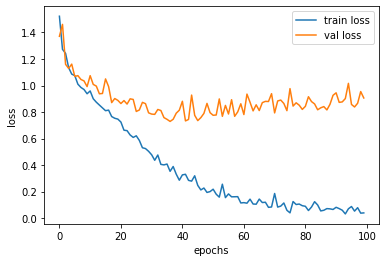

In [ ]:
get_loss(H_, 100)

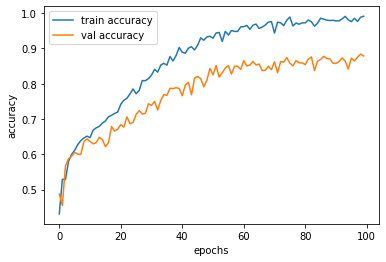

In [ ]:
get_acc(H_, 100)

## model 75k param, 42 feature

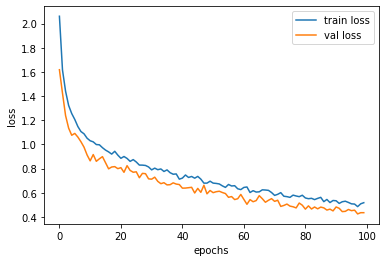

In [ ]:
get_loss(H_1, 100)

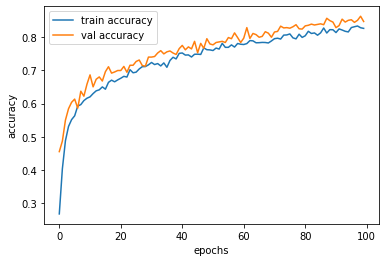

In [ ]:
get_acc(H_1, 100)

In [ ]:
print(x_train.shape)
print(y_train)
print(x_val) 
print(y_val) 
print(x_test) 
print(y_test)

In [ ]:
x_train_path = "/content/x_train.npy"
y_train_path = "/content/y_train.npy"
x_val_path = "/content/x_val.npy"
y_val_path = "/content/y_val.npy"
x_test_path = "/content/x_test.npy"
y_test_path = "/content/y_test.npy"

In [ ]:
np.save(x_train_path, x_train)
np.save(y_train_path, y_train)
np.save(x_val_path, x_val)
np.save(y_val_path, y_val)
np.save(x_test_path, x_test)
np.save(y_test_path, y_test)

In [ ]:
arr_test = np.load(x_train_path)
arr_test.shape

(3635, 42)

In [ ]:
model.save_weights('/content')

In [68]:
!mkdir -p saved_model_300
model.save('/content/saved_model_300/model_lstm_300')

INFO:tensorflow:Assets written to: /content/saved_model_300/model_lstm_300/assets


INFO:tensorflow:Assets written to: /content/saved_model_300/model_lstm_300/assets


In [69]:
!mkdir -p saved_model_75
model1.save('/content/saved_model_75/model_lstm_75')

INFO:tensorflow:Assets written to: /content/saved_model_75/model_lstm_75/assets


INFO:tensorflow:Assets written to: /content/saved_model_75/model_lstm_75/assets


In [70]:
!zip -r saved_model_lstm_300.zip /content/saved_model_300

  adding: content/saved_model_300/ (stored 0%)
  adding: content/saved_model_300/model_lstm_300/ (stored 0%)
  adding: content/saved_model_300/model_lstm_300/assets/ (stored 0%)
  adding: content/saved_model_300/model_lstm_300/keras_metadata.pb (deflated 90%)
  adding: content/saved_model_300/model_lstm_300/saved_model.pb (deflated 90%)
  adding: content/saved_model_300/model_lstm_300/variables/ (stored 0%)
  adding: content/saved_model_300/model_lstm_300/variables/variables.index (deflated 64%)
  adding: content/saved_model_300/model_lstm_300/variables/variables.data-00000-of-00001 (deflated 7%)


In [71]:
!zip -r saved_model_lstm_75.zip /content/saved_model_75

  adding: content/saved_model_75/ (stored 0%)
  adding: content/saved_model_75/model_lstm_75/ (stored 0%)
  adding: content/saved_model_75/model_lstm_75/assets/ (stored 0%)
  adding: content/saved_model_75/model_lstm_75/keras_metadata.pb (deflated 92%)
  adding: content/saved_model_75/model_lstm_75/saved_model.pb (deflated 90%)
  adding: content/saved_model_75/model_lstm_75/variables/ (stored 0%)
  adding: content/saved_model_75/model_lstm_75/variables/variables.index (deflated 70%)
  adding: content/saved_model_75/model_lstm_75/variables/variables.data-00000-of-00001 (deflated 9%)


In [72]:
%cd /content

/content


In [73]:
model.save_weights('./checkpoints_300/voice_lstm_300')

In [74]:
model1.save_weights('./checkpoints_75/voice_lstm_75')

In [75]:
!zip -r checkpoint_lstm_300.zip /content/checkpoints_300
!zip -r checkpoint_lstm_75.zip /content/checkpoints_75

  adding: content/checkpoints_300/ (stored 0%)
  adding: content/checkpoints_300/checkpoint (deflated 39%)
  adding: content/checkpoints_300/voice_lstm_300.data-00000-of-00001 (deflated 7%)
  adding: content/checkpoints_300/voice_lstm_300.index (deflated 64%)
  adding: content/checkpoints_75/ (stored 0%)
  adding: content/checkpoints_75/checkpoint (deflated 39%)
  adding: content/checkpoints_75/voice_lstm_75.index (deflated 70%)
  adding: content/checkpoints_75/voice_lstm_75.data-00000-of-00001 (deflated 8%)
